In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import yaml
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import timm
from torchvision import models

from src.data_ingestion import get_cifar10_dataloaders



In [2]:
import os
print(os.getcwd())


/Users/sanketsushantpai/Desktop/tradingBot/vision-transformer-explainability-system/research


In [3]:
with open("../config.yaml") as f:
    cfg = yaml.safe_load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, test_loader = get_cifar10_dataloaders(cfg)

In [4]:

model = timm.create_model(
    "vit_tiny_patch16_224",
    pretrained=True,
    num_classes=10
)
state_dict = torch.load("best_vit.pt", map_location=device)
print(state_dict.keys())


model.to(device)


dict_keys(['model_name', 'img_size', 'num_classes', 'state_dict'])


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


In [5]:
print(model.pos_embed.shape)
x, _ = next(iter(test_loader))
print(x.shape)


torch.Size([1, 197, 192])


torch.Size([64, 3, 224, 224])


In [14]:
correct = 0
total = 0
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total

accuracy = evaluate(model, train_loader)
accuracy


0.08248

In [7]:
print("model img_size:", model.patch_embed.img_size)
print("patch size:", model.patch_embed.patch_size)
print("pos_embed:", model.pos_embed.shape)


model img_size: (224, 224)
patch size: (16, 16)
pos_embed: torch.Size([1, 197, 192])


In [8]:
images, labels = next(iter(test_loader))
images, labels = next(iter(test_loader))
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0).to(device)
label = labels[0].item()
print(image.shape)
print(label)


torch.Size([1, 3, 224, 224])
3


In [9]:
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0).to(device)
label = labels[0].item()


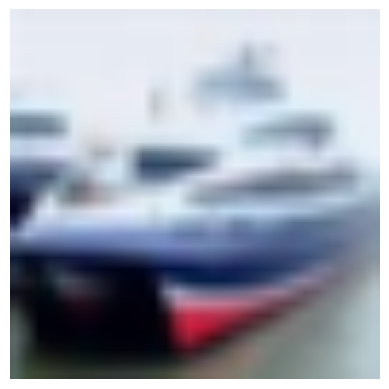

In [10]:
import matplotlib.pyplot as plt

img = images[1].permute(1, 2, 0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)
plt.axis("off")
plt.show()


In [11]:
def attention_rollout(model, x):
    _ = model(x)

    attn_maps = [blk.attn.last_attn for blk in model.blocks]

    rollout = torch.eye(attn_maps[0].size(-1), device=x.device)

    for attn in attn_maps:
        attn = attn.mean(dim=1)
        rollout = attn @ rollout

    return rollout


In [12]:
import timm.models.vision_transformer as vits

_original_forward = vits.Attention.forward

def patched_forward(self, x, attn_mask=None):
    B, N, C = x.shape

    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
    q, k, v = qkv.permute(2, 0, 3, 1, 4)

    attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)

    self.last_attn = attn.detach()

    attn = self.attn_drop(attn)
    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

vits.Attention.forward = patched_forward


_ = model(image)

rollout = attention_rollout(model, image)
mask = rollout[0, 0, 1:]          # remove CLS token
mask = mask.reshape(14, 14)       # correct grid
mask = mask.detach().cpu().numpy()
mask = (mask - mask.min()) / (mask.max() - mask.min())



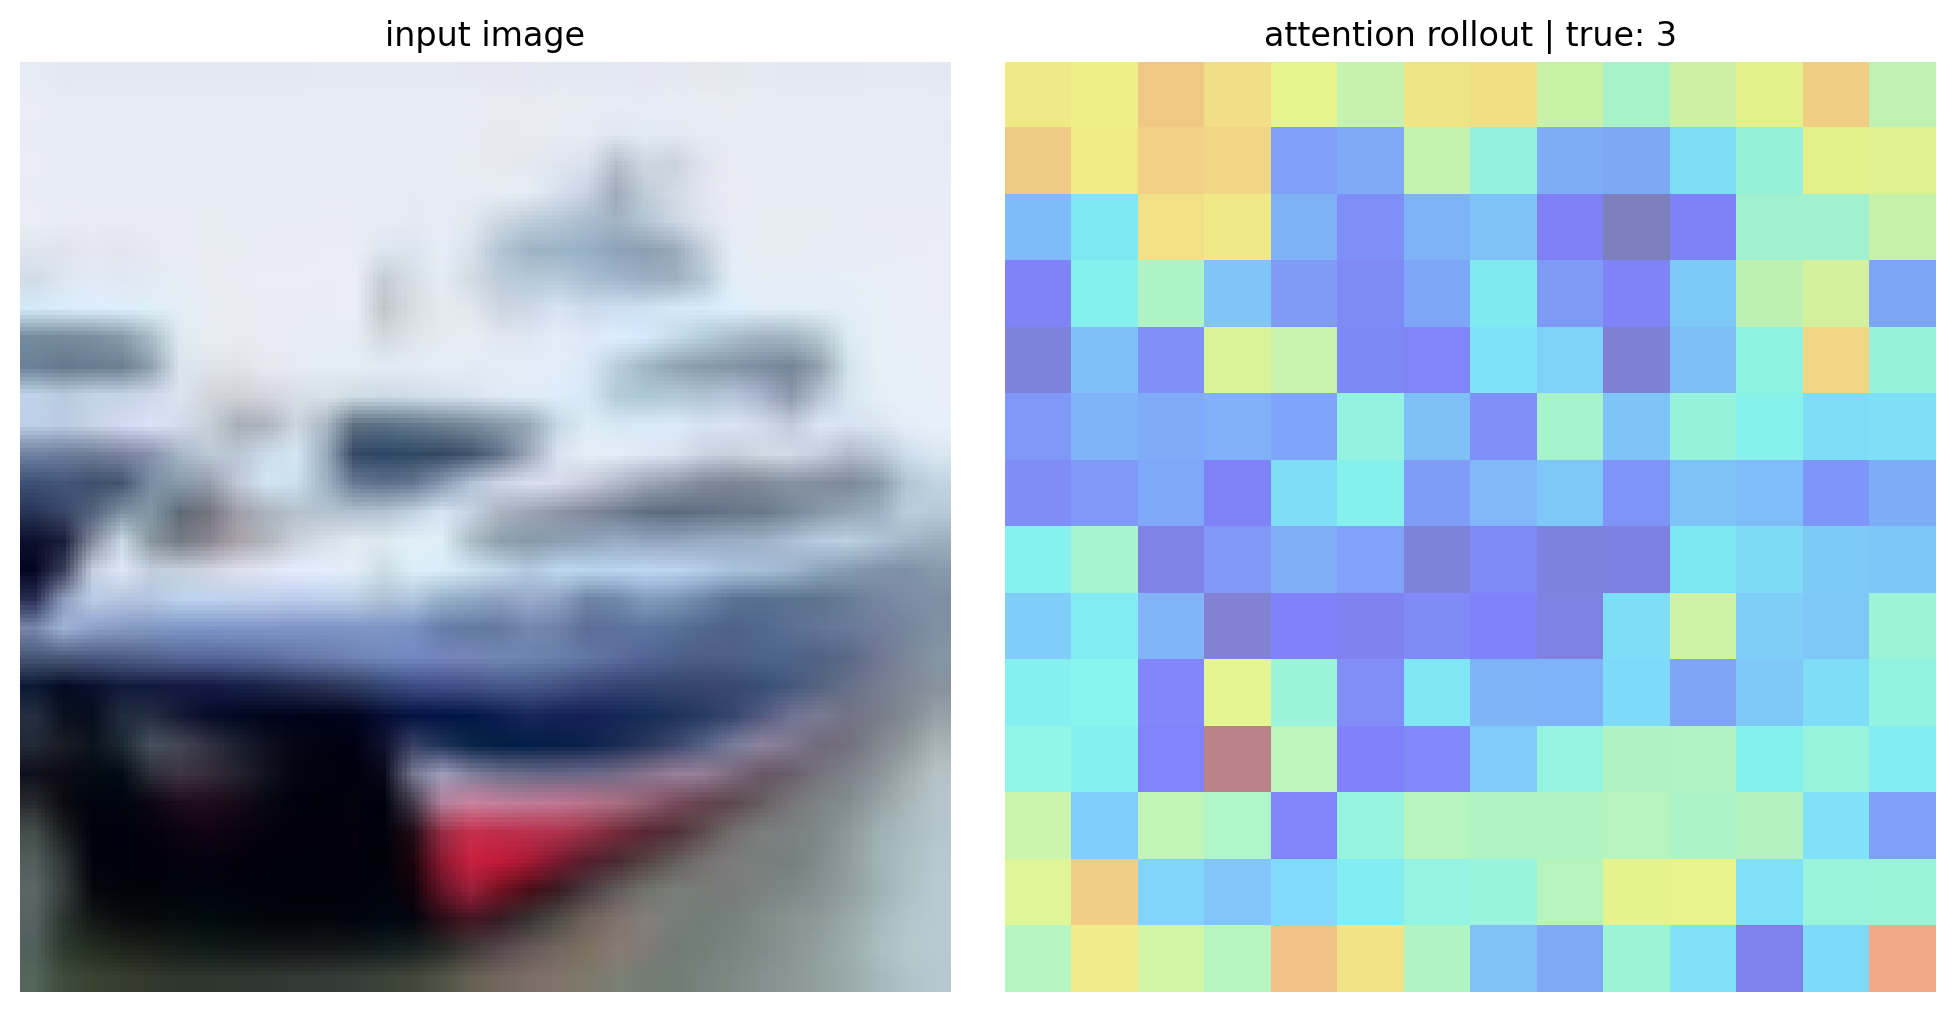

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

axes[0].imshow(img)
axes[0].set_title("input image")
axes[0].axis("off")

axes[1].imshow(img)
axes[1].imshow(mask, cmap="jet", alpha=0.45)
axes[1].set_title(f"attention rollout | true: {label}")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
report = {
    "model": "ViT",
    "accuracy": accuracy,
    "dataset": cfg["data"]["name"],
    "explainability": "attention_rollout"
}

report


{'model': 'ViT',
 'accuracy': 0.0692,
 'dataset': 'cifar10',
 'explainability': 'attention_rollout'}